In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/ml-100k")
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torch
from torch import nn
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
# 导入user_df和item_df
user_df = pd.read_csv("./user_df.csv")
user_df = user_df.iloc[:,1:]
user_df.index += 1
item_df = pd.read_csv("./item_df.csv")
item_df = item_df.iloc[:,1:]
item_df.index += 1

In [ ]:
user_df.head()

,age,gender,occupation
1,2,9,29
2,5,8,23
3,2,9,30
4,2,9,29
5,3,8,23


In [ ]:
item_df.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,30,31,32,34,35,36,36,37,38,39,40,41,42,43,44,45,46,47,48
2,30,32,33,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
3,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,47,48
4,30,32,32,33,34,36,36,37,39,39,40,41,42,43,44,45,46,47,48
5,30,31,32,33,34,35,37,37,39,39,40,41,42,43,44,45,47,47,48


In [ ]:
# 导入user-item交互矩阵
data = pd.read_csv("./user_item2.csv")
data.drop(data.columns[0], axis=1, inplace=True)
data.head()

,user_id,item_id,rating
0,1,55,1
1,1,203,1
2,1,183,1
3,1,150,1
4,1,68,1


In [ ]:
# 获取训练集和测试集
import numpy as np

# 设置随机数生成器的种子
np.random.seed(0)
# 创建一个1到10000的数组
arr = np.arange(data.shape[0])
# 原地随机排列数组
np.random.shuffle(arr)
# 选择百分之多少的数据作为训练集
train_test_ratio = 0.9
# 打乱后的数组的前百分之train_test_ratio(i.e.90%)作为训练集对应的index
train_index = arr[:int(len(arr)*train_test_ratio)]
# 打乱后的数组的后百分之(1-train_test_ratio)(i.e.10%)作为测试集对应的index
test_index = arr[int(len(arr)*train_test_ratio):]
# 获取训练集和测试集
train_set = data.iloc[train_index,:]
test_set = data.iloc[test_index, :]

# 将训练集和测试集的每一行都变成一个元组，方便后续处理
train_set = [tuple(row) for row in train_set.itertuples(index=False, name=None)]
test_set = [tuple(row) for row in test_set.itertuples(index=False, name=None)]

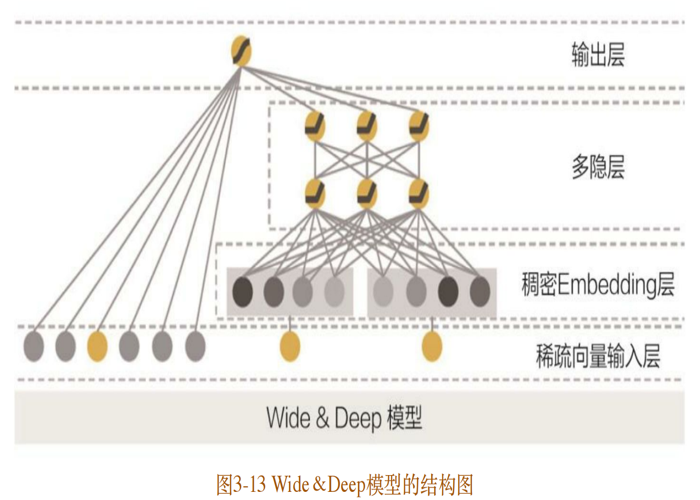

In [3]:
from PIL import Image
os.chdir("/content/drive/MyDrive/Colab Notebooks/推荐系统/推荐系统算法复现/图片")
image_path = "./deep&wide.png"
image = Image.open(image_path)
new_size = (700, 500)
resized_image = image.resize(new_size)
resized_image

In [ ]:
class Deep_wide( nn.Module ):
    def __init__( self, feature_num, user_df, item_df, hidden_dim = 64 ):
        super( Deep_wide, self ).__init__( )
        #随机初始化所有特征的特征向量
        self.features = nn.Embedding(feature_num, hidden_dim, max_norm = 1 )
        # 记录好用户和物品的特征索引
        self.user_df = user_df
        self.item_df = item_df
        # 得到user_df和item_df的特征个数之和
        total_feature_num = user_df.shape[1] + item_df.shape[1]
        #初始化MLP层
        self.mlp_layer = self.__mlp( hidden_dim * total_feature_num )
        # 线性层
        self.linear_layer = nn.Linear(hidden_dim * total_feature_num, 1)

    def __mlp( self, hidden_dim):
        return nn.Sequential(
            nn.Linear( hidden_dim, hidden_dim // 2 ),
            nn.ReLU( ),
            nn.Linear( hidden_dim // 2, 1 ),
            nn.Sigmoid( ) )

    #线性部分
    def Linear_part( self, feature_embs ):
        # feature_embs最开始的shape为(batch_size, feature_num, hidden_dim)
        # feature_embs进行reshape后的shape为(batch_size, total_feature_num * hidden_dim)
        feature_embs = feature_embs.reshape((feature_embs.shape[0], -1 ) )
        # output的shape为(batch_size, 1)
        output = self.linear_layer( feature_embs )
        # 最终输出的shape为(batch_size)
        return torch.squeeze( output )

    #DNN部分
    def Deep_part( self, feature_embs ):
        # feature_embs最开始的shape为(batch_size, feature_num, hidden_dim)
        # feature_embs进行reshape后的shape为(batch_size, total_feature_num * hidden_dim)
        feature_embs = feature_embs.reshape((feature_embs.shape[0], -1 ) )
        # output的shape为(batch_size, 1)
        output = self.mlp_layer( feature_embs )
        # 最终输出的output为(batch_size)
        return torch.squeeze( output )

    #把用户和物品的特征合并起来
    def concat_user_item_vec( self, u, i ):
      # users的shape为(batch_size, users表格的特征个数)
      users = torch.LongTensor( self.user_df.loc[u].values )
      # items的shape为(batch_size, items表格的特征个数)
      items = torch.LongTensor( self.item_df.loc[i].values )
      # concat_vec的shape为(batch_size, users表格的特征个数+items表格的特征个数)
      concat_vec = torch.cat( [ users, items ], dim = 1 )
      return concat_vec

    def forward( self, u, i ):
        # 得到用户与物品组合起来后的特征索引
        # concat_vec_index的shape为(batch_size, users表格的特征个数+items表格的特征个数)
        concat_vec_index = self.concat_user_item_vec( u, i )
        # 通过Embedding层，得到concat_vec_index中每个值对应的隐向量
        # concat_vec_embs的shape为(batch_size, users表格的特征个数+items表格的特征个数, hidden_dim )
        concat_vec_embs = self.features( concat_vec_index )
        # fm_out的shape为(batch_size)
        linear_out = self.Linear_part( concat_vec_embs )
        # deep_out的shape为(batch_size)
        deep_out = self.Deep_part( concat_vec_embs )
        # [batch_size]
        out = torch.sigmoid( linear_out + deep_out )
        return out

In [ ]:
# 实例化模型
# features_values_count的含义是每个特征取值个数的总和，
#比如某数据集的特征A有0,1,2三个取值，B有3，4两个取值，那么features_values_count = 5
features_values_count = max(item_df.values.reshape(-1)) + 1 #加1是因为把特征做编码时，编码最开始的值是0
model =  Deep_wide(features_values_count, user_df, item_df)

In [ ]:
def evaluation(y_pred, y_true):
  p = precision_score(y_true, y_pred)
  r = recall_score(y_true, y_pred)
  acc = accuracy_score(y_true,y_pred)
  return p,r,acc

In [ ]:
# 实例化损失函数和优化器
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score,recall_score,accuracy_score
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
  for user, item, rating in DataLoader(train_set, batch_size=512, shuffle=True):
    # 清空梯度
    optimizer.zero_grad()
    # 前向传播
    predictions = model(user, item)
    # 计算损失
    loss = loss_fn(predictions, rating.float())
    # 反向传播
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch}, Loss: {loss.item()}")

  # 训练集
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = rating.detach().numpy()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('train: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))

  #测试集
  user_test = torch.tensor(test_set)[:,0].detach()
  item_test = torch.tensor(test_set)[:,1].detach()
  predictions = model(user_test, item_test)
  y_pred = np.array([1 if i >= 0.5 else 0 for i in predictions])
  y_true = torch.tensor(test_set)[:,2].detach().float()
  precision, recall, acc = evaluation(y_pred, y_true)
  print('test: Precision {:.4f} | Recall {:.4f} | accuracy {:.4f}'.format(precision, recall, acc))
  print('----------------------------------------------------------------------------------------')

Epoch 0, Loss: 0.6880419850349426
train: Precision 0.6154 | Recall 0.5505 | accuracy 0.5675
test: Precision 0.6302 | Recall 0.5421 | accuracy 0.5658
----------------------------------------------------------------------------------------
Epoch 1, Loss: 0.682105541229248
train: Precision 0.5918 | Recall 0.7768 | accuracy 0.5750
test: Precision 0.5995 | Recall 0.7893 | accuracy 0.5871
----------------------------------------------------------------------------------------
Epoch 2, Loss: 0.6772743463516235
train: Precision 0.5778 | Recall 0.6132 | accuracy 0.5575
test: Precision 0.6236 | Recall 0.5662 | accuracy 0.5661
----------------------------------------------------------------------------------------
Epoch 3, Loss: 0.6616488099098206
train: Precision 0.5900 | Recall 0.8551 | accuracy 0.6175
test: Precision 0.6048 | Recall 0.7321 | accuracy 0.5825
----------------------------------------------------------------------------------------
Epoch 4, Loss: 0.6640090346336365
train: Precisio